In [1]:
import numpy as np
import librosa
from numpy import genfromtxt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from librosa import display
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras import layers, models
print(tf.__version__)

2.4.1


In [2]:
# Parameter
num_of_class = 1
shape = 40

In [3]:
x_train = genfromtxt('train_data.csv', delimiter=',')
y_train = genfromtxt('train_labels.csv', delimiter=',')
x_test  = genfromtxt('test_data.csv', delimiter=',')
y_test  = genfromtxt('test_labels.csv', delimiter=',')
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((675, 40), (171, 40), (675,), (171,))

In [4]:
# Convert to One Hot Data
y_train = to_categorical(y_train, num_classes = num_of_class)
y_test  = to_categorical(y_test, num_classes  = num_of_class)
y_train.shape,y_test.shape

((675, 1), (171, 1))

In [117]:
# Reshaping to Shape Required by CNN
x_train = np.reshape(x_train,(x_train.shape[0], shape,1,1))
x_test  = np.reshape(x_test,(x_test.shape[0], shape,1,1))

# Shapes
x_train.shape,x_test.shape

((675, 40, 1, 1), (171, 40, 1, 1))

In [139]:
#forming model
model=Sequential()
#adding layers and forming the model
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,1,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(1,activation="softmax"))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 40, 1, 64)         1664      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 20, 1, 64)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 20, 1, 128)        204928    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 1, 128)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 1, 128)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)             

In [140]:
# Compiling
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [128]:
# Training the model
model.fit(x_train,y_train,batch_size=50,epochs=1,validation_data=(x_test,y_test))

14/14 [==============================] - 1s 58ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [129]:
# train and test loss and scores respectively
train_loss_score=model.evaluate(x_train,y_train)
test_loss_score=model.evaluate(x_test,y_test)
print(train_loss_score)
print(test_loss_score)

6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
[0.0, 1.0]
[0.0, 1.0]


In [130]:
model.save('panikee')

INFO:tensorflow:Assets written to: panikee/assets


INFO:tensorflow:Assets written to: panikee/assets


In [131]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('panikeemodel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0p37umce/assets


INFO:tensorflow:Assets written to: /tmp/tmp0p37umce/assets


In [132]:
x_test[0].shape

(40, 1, 1)

In [133]:
testData = np.expand_dims(x_test[6],axis=0)

In [134]:
prediction = model.predict(testData)

In [135]:
prediction[0][0]

1.0

In [107]:
y_test[5]

array([1.], dtype=float32)

In [91]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="panikeemodel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [92]:
input_details

[{'name': 'conv2d_12_input',
  'index': 0,
  'shape': array([ 1, 40,  1,  1], dtype=int32),
  'shape_signature': array([-1, 40,  1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [93]:
testData = np.expand_dims(x_test[5],axis=0)
atData = np.float32(testData)

In [136]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], atData)
print(input_data.dtype)
print(testData.shape)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data[0][0])

float32
(1, 40, 1, 1)
nan


1.0


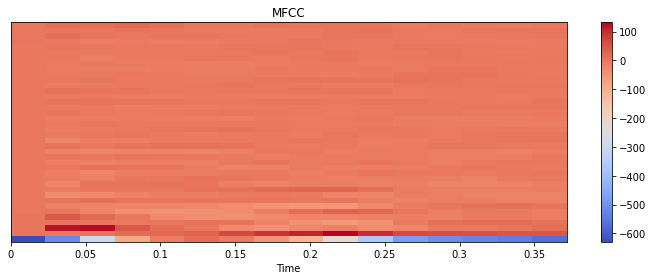

In [138]:
y,sr  = librosa.load("../../Dataset/speech_dataset/zero/0a2b400e_nohash_0.wav", 8000)
mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
mfccss = librosa.feature.mfcc(y, sr, n_mfcc=40)

cek = np.array(mfccs)
cek = np.reshape(cek, (shape, 1, 1))
newShape = np.expand_dims(cek, axis=0)
prediction = model.predict(newShape)
print(prediction[0][0])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccss, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()